### Library Imports

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from operator import add
import os
import time
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, StateGraph
from typing_extensions import Annotated, TypedDict
from dotenv import load_dotenv
from IPython.display import Markdown, display, Image

load_dotenv()


def pretty_print(data):
    if isinstance(data, str):
        display(Markdown(data))
    elif isinstance(data, dict):
        for key, value in data.items():
            display(Markdown(f"**{key}:** {value}"))
    else:
        display(data)


def extract_latency_and_token_usage(graph, state, config):
    """
    Invokes the graph, measures latency, extracts and prints token_usage (total_tokens) and latency.

    Args:
        graph: The compiled LangGraph object.
        state (dict): The state to pass to graph.invoke().
        config (dict): The config to pass to graph.invoke().

    Returns:
        dict: The response object from graph.invoke().
    """
    start_time = time.time()
    response = graph.invoke(state, config)
    end_time = time.time()
    latency = end_time - start_time

    # Assuming the last message is the AIMessage with response_metadata
    last_message = response.get("messages")[-1]
    metadata = (
        last_message.response_metadata
        if hasattr(last_message, "response_metadata")
        else {}
    )

    token_usage = metadata.get("token_usage", {}).get("total_tokens")

    print(f"Total Tokens: {token_usage}")
    print(f"Latency: {latency:.4f} seconds")

    return response


llm = ChatOpenAI(
    model="nvidia/nemotron-3-nano-30b-a3b:free",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
)

### Sliding Window Example 
- In this approach, instead of retaining the entire conversation history, the agent keeps only the most recent N messages as context. As new messages arrive, the oldest ones are dropped, and the window slides forward.
- You can think of it as the agent having a short-term memory buffer. It remembers what just happened, but after a while, starts to forget the earliest parts of the conversation.
-  With a sliding window, tokens per turn grow only until the window is full. After that, the total token count stabilizes, because older messages are being dropped as new ones come in.
- With a sliding window, tokens per turn grow only until the window is full. After that, the total token count stabilizes, because older messages are being dropped as new ones come in.
- Anything that falls of the window is wiped off the agent's memory.


In [14]:
class SlidingMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], lambda a, b: b]  # Replace reducer
    new_message: list[AnyMessage]  # No reducer

In [15]:
MAX_MESSAGES = 3


def truncate_messages_node(state: SlidingMessagesState):
    messages = state["messages"]

    if len(messages) <= MAX_MESSAGES:
        return {}

    pruned = messages[-MAX_MESSAGES:]
    print(len(messages), "messages pruned to", len(pruned))
    return {"messages": pruned}


def add_input_node(state: SlidingMessagesState):
    return {"messages": state["messages"] + state.get("new_message", [])}


def chat_llm_node(state: SlidingMessagesState):
    print(len(state["messages"]), "messages sent to LLM")
    history = [SystemMessage(content="You are a customer support assistant.")]
    history.extend(state["messages"])

    reply = llm.invoke(history)

    return {"messages": state["messages"] + [reply]}

In [16]:
checkpointer = InMemorySaver()

builder = StateGraph(SlidingMessagesState)

builder.add_node("add_input", add_input_node)
builder.add_node("truncate", truncate_messages_node)
builder.add_node("chat_llm", chat_llm_node)

# flow: START -> add_input -> truncate -> chat_llm -> END
builder.add_edge(START, "add_input")
builder.add_edge("add_input", "truncate")
builder.add_edge("truncate", "chat_llm")
builder.add_edge("chat_llm", END)

sliding_graph = builder.compile(checkpointer=checkpointer)

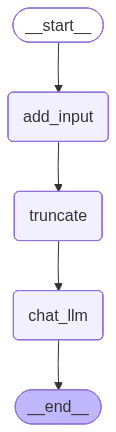

In [17]:
Image(sliding_graph.get_graph().draw_mermaid_png())

#### Turn 1

In [18]:
config = {"configurable": {"thread_id": "ticket-sliding"}}

# Turn 1
state1 = {
    "new_message": [
        HumanMessage(
            content=(
                "Hi, I'm being charged twice for my subscription. "
                "Can you help me figure out what's going on briefly?"
                "My favorite color is blue by the way (not important information, ignore it)"
            )
        )
    ]
}

response1 = extract_latency_and_token_usage(sliding_graph, state1, config)

1 messages sent to LLM
Total Tokens: 488
Latency: 3.4834 seconds


#### Turn 2

In [19]:
state2 = {
    "new_message": [
        HumanMessage(
            content=(
                "I think this started after I changed my billing address last month."
            )
        )
    ]
}

response2 = extract_latency_and_token_usage(sliding_graph, state2, config)

3 messages sent to LLM
Total Tokens: 1066
Latency: 3.5468 seconds


### Turn 3 

In [20]:
state3 = {"new_message": [HumanMessage(content=("What is my favorite color?"))]}
response3 = extract_latency_and_token_usage(sliding_graph, state3, config)

5 messages pruned to 3
3 messages sent to LLM
Total Tokens: 696
Latency: 1.1944 seconds


In [21]:
response3.get("messages")

[HumanMessage(content='I think this started after I changed my billing address last month.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='I’m glad you noticed the timing—changing a billing address can sometimes trigger a duplicate charge. Here’s a quick rundown of why that can happen and what to do:\n\n| Possible cause | What it looks like | Quick fix |\n|----------------|-------------------|-----------|\n| **Payment‑method retry** | The system tried to bill the old address, failed, then retried with the new address. | Check your recent payment history; you’ll often see a “declined” or “failed” entry followed by a successful charge. |\n| **Subscription migration** | When the address changes, some services temporarily create a “new” subscription record, leading to two active bills for a short window. | Verify that only one active subscription appears under your account settings. |\n| **Address‑verification rule** | Some platforms automatically pause or duplicate bill

In [22]:
print("User:")
pretty_print(response3.get("messages")[-2].content)
print(f"AiMessage:")
pretty_print(response3.get("messages")[-1].content)

User:


What is my favorite color?

AiMessage:


I don’t have any way to know your personal favorite color—​that’s something only you can tell me! 🎨 If you’d like to share it, I’d love to hear what hue you’re most drawn to.

### Sequential conversation Example
- This demonstration makes it clear that nothing is ever dropped from context in the sequential memory strategy; the prompt just keeps getting longer.
- From the performance metrics it is clear that the number of prompt tokens grows roughly linearly with the number of turns. This also leads to growing costs, because you pay for all past tokens on every call to the LLM.
- Sequential memory is, therefore, best treated as a baseline as it gives us the most straightforward behavior and is easy to instrument. But it does not scale well.

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add]


def chat_llm_node(state: MessagesState):
    history = [SystemMessage(content="You are a customer support assistant.")]
    history.extend(state["messages"])

    reply = llm.invoke(history)

    return {"messages": [reply]}

#### Compile the Graph

In [ ]:
checkpointer = InMemorySaver()

builder = StateGraph(MessagesState)
builder.add_node("chat_llm", chat_llm_node)
builder.add_edge(START, "chat_llm")
builder.add_edge("chat_llm", END)

graph = builder.compile(checkpointer=checkpointer)

#### Run the sequential conversation graph

##### Turn1 

In [ ]:
config = {"configurable": {"thread_id": "ticket-seq"}}

# Turn 1
state1 = {
    "messages": [
        HumanMessage(
            content=(
                "Hi, I'm being charged twice for my subscription. "
                "Can you help me figure out what's going on briefly?"
            )
        )
    ]
}

response1 = extract_latency_and_token_usage(graph, state1, config)


In [ ]:
print("User:")
pretty_print(response1.get("messages")[-2].content)
print(f"AiMessage:")
pretty_print(response1.get("messages")[-1].content)

#### Turn 2

In [ ]:
state2 = {
    "messages": [
        HumanMessage(
            content=(
                "I think this started after I changed my billing address last month."
            )
        )
    ]
}
response2 = extract_latency_and_token_usage(graph, state2, config)

In [ ]:
print("User:")
pretty_print(response2.get("messages")[-2].content)
print(f"AiMessage:")
pretty_print(response2.get("messages")[-1].content)

#### Turn 3

In [ ]:
state3 = {
    "messages": [HumanMessage(content=("Can you summarize what we did just now?"))]
}
response3 = extract_latency_and_token_usage(graph, state3, config)

In [ ]:
print("User:")
pretty_print(response3.get("messages")[-2].content)
print(f"AiMessage:")
pretty_print(response3.get("messages")[-1].content)